# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    accuracy = 0
    total = 0 
    for (x, y) in loader:
        prediction = model(x)
        _,predicted = torch.max(prediction, 1)
        total+= x.size()[0]
        accuracy += (predicted == y).sum().item()
    #raise Exception("Not implemented")
    
    return accuracy/total

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.818567, Train accuracy: 0.417688, Val accuracy: 0.551020
Average loss: 1.449620, Train accuracy: 0.588029, Val accuracy: 0.605419
Average loss: 1.373182, Train accuracy: 0.622820, Val accuracy: 0.623097


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.335240, Train accuracy: 0.562263, Val accuracy: 0.652106
Average loss: 0.934903, Train accuracy: 0.709415, Val accuracy: 0.697768
Average loss: 0.816964, Train accuracy: 0.747125, Val accuracy: 0.745000
Average loss: 0.746341, Train accuracy: 0.770075, Val accuracy: 0.740769
Average loss: 0.702378, Train accuracy: 0.785107, Val accuracy: 0.755785


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.332533, Train accuracy: 0.565573, Val accuracy: 0.683298
Average loss: 0.946739, Train accuracy: 0.704143, Val accuracy: 0.712033
Average loss: 0.828977, Train accuracy: 0.741460, Val accuracy: 0.768480
Average loss: 0.764310, Train accuracy: 0.764154, Val accuracy: 0.749096
Average loss: 0.722011, Train accuracy: 0.777105, Val accuracy: 0.789571


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    
    sampler = SubsetSampler(indices)
    batch_size = 64
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    
    predictions, ground_truth = [], []
    for (x, y) in loader:
        prediction = model(x)    

        indices = torch.argmax(prediction, 1)
        
        predictions.extend(list(indices.numpy()))
        ground_truth.extend(list(y.numpy()))
        
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

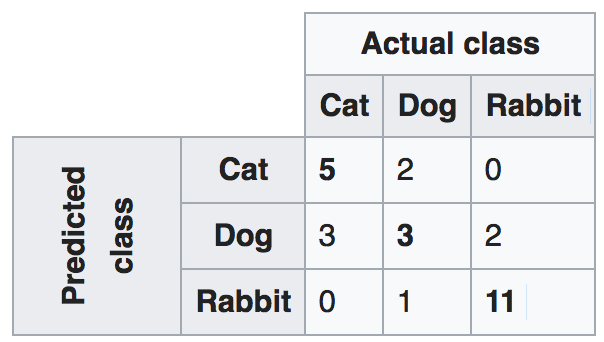

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

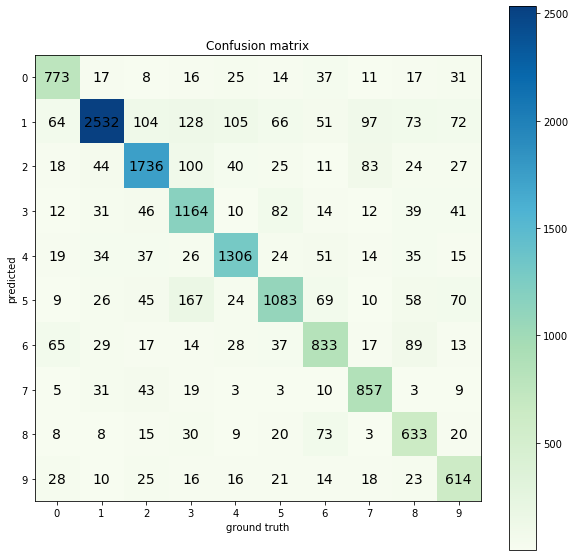

In [11]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    num_class = 10
    confusion_matrix = np.zeros((num_class, num_class), np.int)
    
    for i in range(num_class):
        for j in range(num_class):
            confusion_matrix[i, j] = np.sum(predictions[ground_truth == j] == i)
#             confusion_matrix[i, j] = np.sum((ground_truth == j) & (predictions == i))  # alternative variant
    
    # TODO: Implement filling the prediction matrix
#     return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

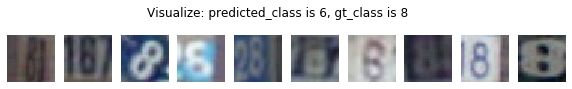

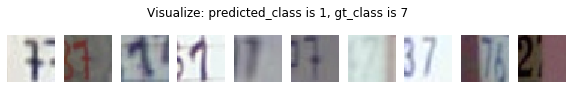

In [12]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")
    title = f"Visualize: predicted_class is {predicted_class}, gt_class is {gt_class}"
    indices = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    
    visualize_images(indices, data, title, max_num=10)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

Начинаем эксперименты!

In [13]:
# Experiment here!

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        if scheduler:
            scheduler.step()  # use the sheduler
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();

1)

In [14]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.779187, Train accuracy: 0.453896, Val accuracy: 0.597775
Average loss: 1.483208, Train accuracy: 0.618742, Val accuracy: 0.648488
Average loss: 1.426329, Train accuracy: 0.644934, Val accuracy: 0.677428
Average loss: 1.375668, Train accuracy: 0.674231, Val accuracy: 0.691898
Average loss: 1.365631, Train accuracy: 0.681568, Val accuracy: 0.701590
Average loss: 1.342081, Train accuracy: 0.698563, Val accuracy: 0.713262
Average loss: 1.337591, Train accuracy: 0.703324, Val accuracy: 0.722135
Average loss: 1.324092, Train accuracy: 0.714398, Val accuracy: 0.733329
Average loss: 1.321192, Train accuracy: 0.715814, Val accuracy: 0.728960
Average loss: 1.314804, Train accuracy: 0.721701, Val accuracy: 0.732783
Average loss: 1.311941, Train accuracy: 0.723595, Val accuracy: 0.739472
Average loss: 1.306915, Train accuracy: 0.725950, Val accuracy: 0.741519
Average loss: 1.305637, Train accuracy: 0.727690, Val accuracy: 0.738448
Average loss: 1.303956, Train accuracy: 0.731290, V

In [15]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7206


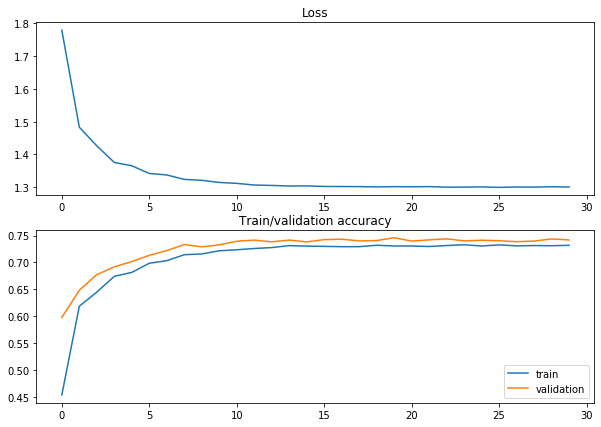

In [16]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [15]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 2.084451, Train accuracy: 0.292291, Val accuracy: 0.461743
Average loss: 1.767184, Train accuracy: 0.499863, Val accuracy: 0.562624
Average loss: 1.601229, Train accuracy: 0.579872, Val accuracy: 0.622210
Average loss: 1.489862, Train accuracy: 0.620465, Val accuracy: 0.657293
Average loss: 1.404626, Train accuracy: 0.649695, Val accuracy: 0.674152
Average loss: 1.335596, Train accuracy: 0.668464, Val accuracy: 0.697905
Average loss: 1.273755, Train accuracy: 0.683770, Val accuracy: 0.700840
Average loss: 1.219729, Train accuracy: 0.695219, Val accuracy: 0.719814
Average loss: 1.171629, Train accuracy: 0.706600, Val accuracy: 0.727459
Average loss: 1.127295, Train accuracy: 0.717640, Val accuracy: 0.733602
Average loss: 1.091944, Train accuracy: 0.724363, Val accuracy: 0.743567
Average loss: 1.059776, Train accuracy: 0.730557, Val accuracy: 0.747389
Average loss: 1.033210, Train accuracy: 0.737894, Val accuracy: 0.756331
Average loss: 1.009192, Train accuracy: 0.744787, V

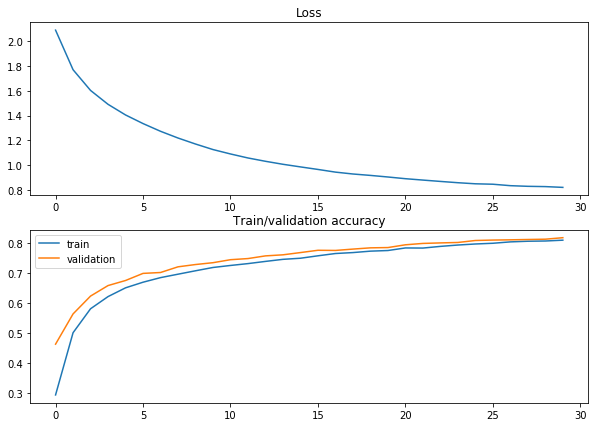

In [16]:
loss_accuracy_plot(loss_history, train_history, val_history)



In [17]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7946


In [27]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 2.094617, Train accuracy: 0.288571, Val accuracy: 0.456556
Average loss: 1.750372, Train accuracy: 0.527301, Val accuracy: 0.593953
Average loss: 1.584716, Train accuracy: 0.601662, Val accuracy: 0.646167
Average loss: 1.473951, Train accuracy: 0.636164, Val accuracy: 0.670807
Average loss: 1.386981, Train accuracy: 0.658277, Val accuracy: 0.689578
Average loss: 1.314658, Train accuracy: 0.675545, Val accuracy: 0.694492
Average loss: 1.250252, Train accuracy: 0.687489, Val accuracy: 0.715105
Average loss: 1.197203, Train accuracy: 0.702368, Val accuracy: 0.723159
Average loss: 1.149957, Train accuracy: 0.713084, Val accuracy: 0.728346
Average loss: 1.109311, Train accuracy: 0.721530, Val accuracy: 0.736742
Average loss: 1.071543, Train accuracy: 0.728833, Val accuracy: 0.746843
Average loss: 1.039296, Train accuracy: 0.739651, Val accuracy: 0.759129
Average loss: 1.010436, Train accuracy: 0.746903, Val accuracy: 0.761654
Average loss: 0.986015, Train accuracy: 0.753302, V

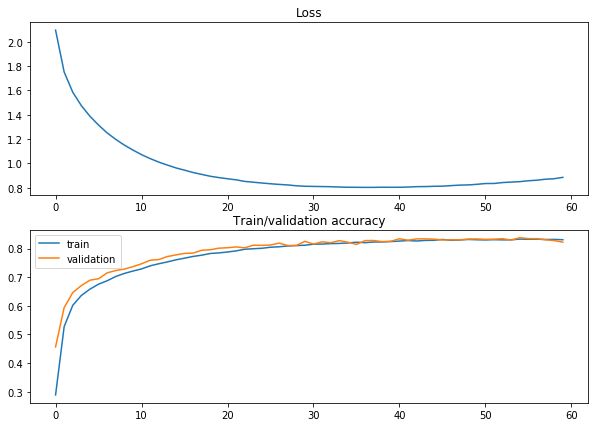

In [28]:
loss_accuracy_plot(loss_history, train_history, val_history)


In [29]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8029


In [31]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.593166, Train accuracy: 0.522353, Val accuracy: 0.666166
Average loss: 1.128096, Train accuracy: 0.681108, Val accuracy: 0.722067
Average loss: 0.965259, Train accuracy: 0.718732, Val accuracy: 0.752918
Average loss: 0.868254, Train accuracy: 0.745128, Val accuracy: 0.779605
Average loss: 0.805206, Train accuracy: 0.765297, Val accuracy: 0.781721
Average loss: 0.764685, Train accuracy: 0.775859, Val accuracy: 0.794075
Average loss: 0.743238, Train accuracy: 0.782838, Val accuracy: 0.786567
Average loss: 0.720825, Train accuracy: 0.790636, Val accuracy: 0.793871
Average loss: 0.703767, Train accuracy: 0.796147, Val accuracy: 0.816941
Average loss: 0.689267, Train accuracy: 0.799816, Val accuracy: 0.810184
Average loss: 0.680131, Train accuracy: 0.803501, Val accuracy: 0.823289
Average loss: 0.671960, Train accuracy: 0.805054, Val accuracy: 0.816054
Average loss: 0.662449, Train accuracy: 0.809371, Val accuracy: 0.823903
Average loss: 0.658855, Train accuracy: 0.811350, V

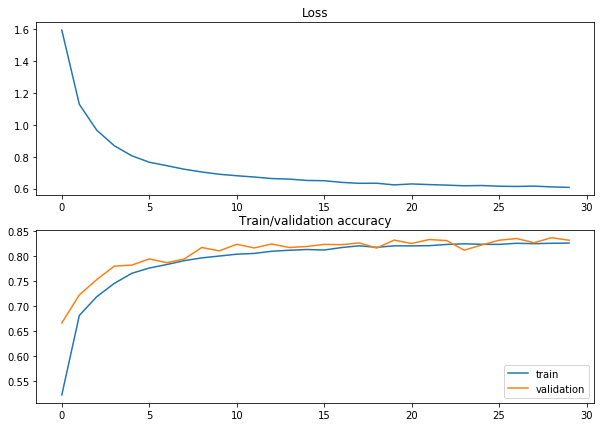

In [32]:
loss_accuracy_plot(loss_history, train_history, val_history)


In [33]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8077


5)

In [36]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.534698, Train accuracy: 0.548647, Val accuracy: 0.678111
Average loss: 1.067424, Train accuracy: 0.698188, Val accuracy: 0.723159
Average loss: 0.898264, Train accuracy: 0.738525, Val accuracy: 0.763020
Average loss: 0.815249, Train accuracy: 0.763898, Val accuracy: 0.792301
Average loss: 0.765267, Train accuracy: 0.775330, Val accuracy: 0.780971
Average loss: 0.732185, Train accuracy: 0.785739, Val accuracy: 0.803631
Average loss: 0.706735, Train accuracy: 0.795431, Val accuracy: 0.785612
Average loss: 0.687412, Train accuracy: 0.798468, Val accuracy: 0.795099
Average loss: 0.675886, Train accuracy: 0.804645, Val accuracy: 0.807999
Average loss: 0.661888, Train accuracy: 0.809764, Val accuracy: 0.819057
Average loss: 0.654046, Train accuracy: 0.811009, Val accuracy: 0.824244
Average loss: 0.649405, Train accuracy: 0.812596, Val accuracy: 0.810661
Average loss: 0.639927, Train accuracy: 0.817237, Val accuracy: 0.809160
Average loss: 0.637419, Train accuracy: 0.815855, V

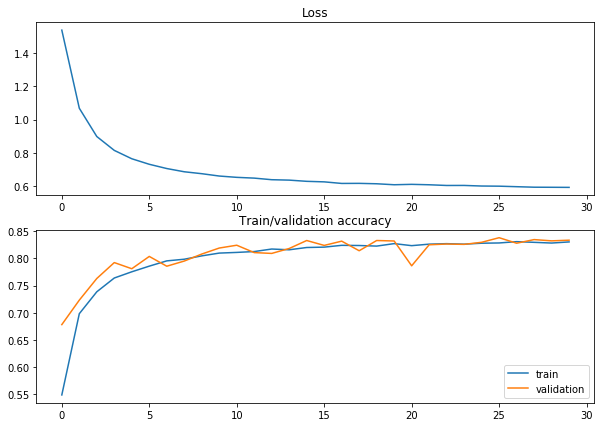

In [37]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [38]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8095


In [12]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 80), 
            nn.BatchNorm1d(80), 
            nn.ReLU(inplace=True), 
            nn.Linear(80, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.637949, Train accuracy: 0.512695, Val accuracy: 0.642960
Average loss: 1.172745, Train accuracy: 0.670648, Val accuracy: 0.695106
Average loss: 0.993779, Train accuracy: 0.713613, Val accuracy: 0.755102
Average loss: 0.889968, Train accuracy: 0.741596, Val accuracy: 0.768958
Average loss: 0.828628, Train accuracy: 0.759615, Val accuracy: 0.781790
Average loss: 0.779901, Train accuracy: 0.772651, Val accuracy: 0.790526
Average loss: 0.750472, Train accuracy: 0.783026, Val accuracy: 0.809433
Average loss: 0.728774, Train accuracy: 0.789527, Val accuracy: 0.818306
Average loss: 0.711084, Train accuracy: 0.793485, Val accuracy: 0.810593
Average loss: 0.697063, Train accuracy: 0.798877, Val accuracy: 0.809296
Average loss: 0.685223, Train accuracy: 0.802170, Val accuracy: 0.815712
Average loss: 0.676536, Train accuracy: 0.805481, Val accuracy: 0.815849
Average loss: 0.666433, Train accuracy: 0.807494, Val accuracy: 0.815849
Average loss: 0.655804, Train accuracy: 0.813500, V

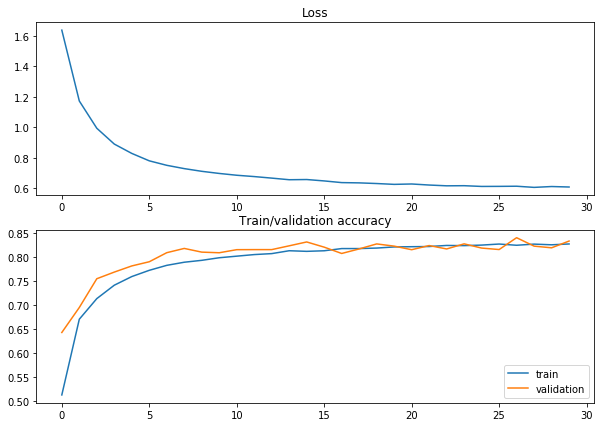

In [13]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [14]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8101


7)

In [15]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),  
            nn.ReLU(inplace=True), 
            nn.Linear(100, 80),  
            nn.ReLU(inplace=True), 
            nn.Linear(80, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.233735, Train accuracy: 0.603317, Val accuracy: 0.714149
Average loss: 0.883837, Train accuracy: 0.727315, Val accuracy: 0.730803
Average loss: 0.773156, Train accuracy: 0.763113, Val accuracy: 0.757354
Average loss: 0.702507, Train accuracy: 0.786097, Val accuracy: 0.780015
Average loss: 0.655565, Train accuracy: 0.800566, Val accuracy: 0.786363
Average loss: 0.622837, Train accuracy: 0.808944, Val accuracy: 0.793052
Average loss: 0.590966, Train accuracy: 0.819046, Val accuracy: 0.801515
Average loss: 0.560768, Train accuracy: 0.827100, Val accuracy: 0.808819
Average loss: 0.547103, Train accuracy: 0.831109, Val accuracy: 0.799195
Average loss: 0.533178, Train accuracy: 0.835887, Val accuracy: 0.794895
Average loss: 0.519028, Train accuracy: 0.840136, Val accuracy: 0.782472
Average loss: 0.498473, Train accuracy: 0.844385, Val accuracy: 0.820968
Average loss: 0.488639, Train accuracy: 0.848360, Val accuracy: 0.804382
Average loss: 0.475252, Train accuracy: 0.853121, V

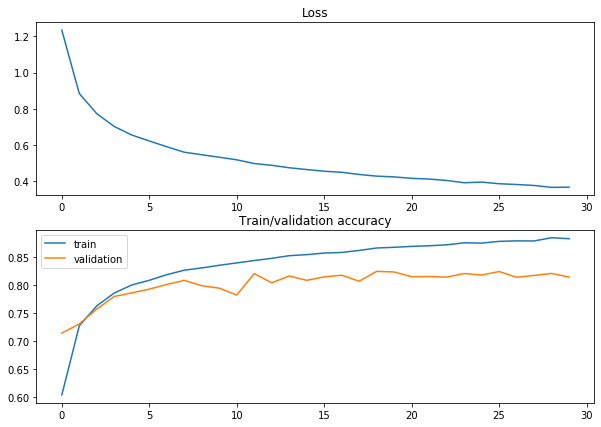

In [16]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [17]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7848


8)


In [18]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),  
            nn.ReLU(inplace=True), 
            nn.Linear(100, 80),  
            nn.ReLU(inplace=True), 
            nn.Linear(80, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.238152, Train accuracy: 0.599819, Val accuracy: 0.715719
Average loss: 0.866109, Train accuracy: 0.735198, Val accuracy: 0.742202
Average loss: 0.751070, Train accuracy: 0.770075, Val accuracy: 0.770801
Average loss: 0.693164, Train accuracy: 0.786899, Val accuracy: 0.770186
Average loss: 0.643662, Train accuracy: 0.803672, Val accuracy: 0.796191
Average loss: 0.611515, Train accuracy: 0.812988, Val accuracy: 0.795304
Average loss: 0.585148, Train accuracy: 0.821793, Val accuracy: 0.809160
Average loss: 0.561338, Train accuracy: 0.828499, Val accuracy: 0.802061
Average loss: 0.543390, Train accuracy: 0.833686, Val accuracy: 0.802744
Average loss: 0.524749, Train accuracy: 0.837525, Val accuracy: 0.805815
Average loss: 0.510682, Train accuracy: 0.841569, Val accuracy: 0.808341
Average loss: 0.496720, Train accuracy: 0.844965, Val accuracy: 0.810593
Average loss: 0.487715, Train accuracy: 0.848224, Val accuracy: 0.808409
Average loss: 0.475385, Train accuracy: 0.852114, V

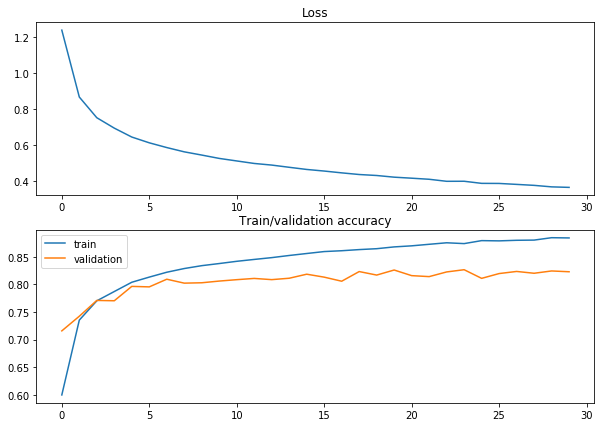

In [19]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [20]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7980


9)

In [24]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.342508, Train accuracy: 0.565676, Val accuracy: 0.708416
Average loss: 0.937642, Train accuracy: 0.705116, Val accuracy: 0.748413
Average loss: 0.815303, Train accuracy: 0.744617, Val accuracy: 0.775783
Average loss: 0.747754, Train accuracy: 0.766099, Val accuracy: 0.800082
Average loss: 0.695023, Train accuracy: 0.782599, Val accuracy: 0.791277
Average loss: 0.659308, Train accuracy: 0.793741, Val accuracy: 0.808887
Average loss: 0.627248, Train accuracy: 0.803638, Val accuracy: 0.820012
Average loss: 0.601761, Train accuracy: 0.812374, Val accuracy: 0.815098
Average loss: 0.582239, Train accuracy: 0.818739, Val accuracy: 0.808477
Average loss: 0.563321, Train accuracy: 0.822527, Val accuracy: 0.821377
Average loss: 0.548049, Train accuracy: 0.826042, Val accuracy: 0.831889
Average loss: 0.539125, Train accuracy: 0.828465, Val accuracy: 0.834073
Average loss: 0.525296, Train accuracy: 0.832065, Val accuracy: 0.831684
Average loss: 0.509191, Train accuracy: 0.838617, V

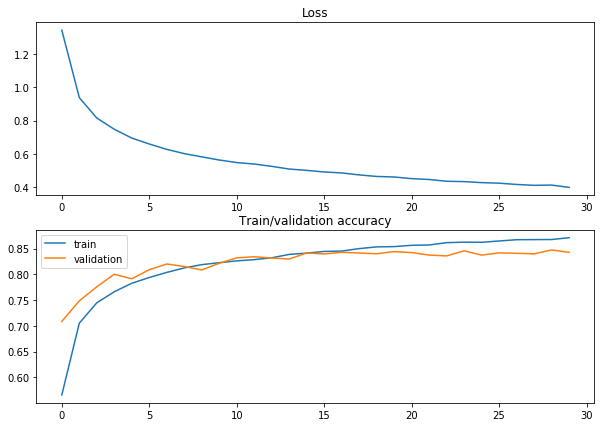

In [25]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [26]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8098


In [27]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 15  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.354984, Train accuracy: 0.558714, Val accuracy: 0.708894
Average loss: 0.924590, Train accuracy: 0.709381, Val accuracy: 0.754283
Average loss: 0.803910, Train accuracy: 0.748524, Val accuracy: 0.786499
Average loss: 0.725824, Train accuracy: 0.773266, Val accuracy: 0.784656
Average loss: 0.680902, Train accuracy: 0.788298, Val accuracy: 0.807590
Average loss: 0.642608, Train accuracy: 0.798928, Val accuracy: 0.806293
Average loss: 0.614607, Train accuracy: 0.808808, Val accuracy: 0.817965
Average loss: 0.593467, Train accuracy: 0.813466, Val accuracy: 0.818852
Average loss: 0.576097, Train accuracy: 0.819592, Val accuracy: 0.821582
Average loss: 0.556176, Train accuracy: 0.825257, Val accuracy: 0.827316
Average loss: 0.544406, Train accuracy: 0.828311, Val accuracy: 0.832981
Average loss: 0.523937, Train accuracy: 0.836587, Val accuracy: 0.819603
Average loss: 0.515133, Train accuracy: 0.838071, Val accuracy: 0.834619
Average loss: 0.502795, Train accuracy: 0.842542, V

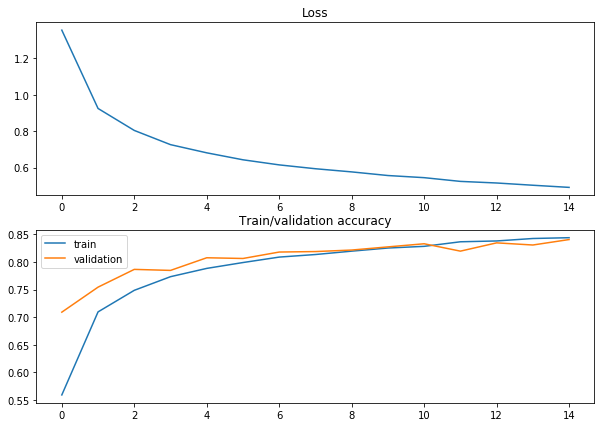

In [28]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [29]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8132


10)

In [30]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.312850, Train accuracy: 0.577347, Val accuracy: 0.705959
Average loss: 0.911418, Train accuracy: 0.714722, Val accuracy: 0.753191
Average loss: 0.783426, Train accuracy: 0.754496, Val accuracy: 0.781721
Average loss: 0.705375, Train accuracy: 0.780364, Val accuracy: 0.799263
Average loss: 0.652677, Train accuracy: 0.796011, Val accuracy: 0.795987
Average loss: 0.609642, Train accuracy: 0.810207, Val accuracy: 0.824176
Average loss: 0.585957, Train accuracy: 0.816094, Val accuracy: 0.821787
Average loss: 0.557109, Train accuracy: 0.824916, Val accuracy: 0.820558
Average loss: 0.537582, Train accuracy: 0.831826, Val accuracy: 0.822401
Average loss: 0.519861, Train accuracy: 0.836587, Val accuracy: 0.827862
Average loss: 0.500968, Train accuracy: 0.842525, Val accuracy: 0.828408
Average loss: 0.488551, Train accuracy: 0.845357, Val accuracy: 0.836871
Average loss: 0.477072, Train accuracy: 0.851176, Val accuracy: 0.837827
Average loss: 0.462792, Train accuracy: 0.854025, V

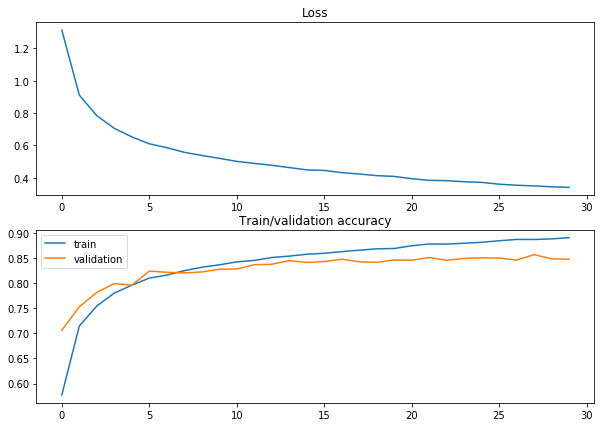

In [31]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [32]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8205


12)

In [37]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-8)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.319458, Train accuracy: 0.573201, Val accuracy: 0.694628
Average loss: 0.900328, Train accuracy: 0.717503, Val accuracy: 0.749846
Average loss: 0.780711, Train accuracy: 0.755315, Val accuracy: 0.781585
Average loss: 0.703661, Train accuracy: 0.778538, Val accuracy: 0.794758
Average loss: 0.661940, Train accuracy: 0.791028, Val accuracy: 0.805952
Average loss: 0.624973, Train accuracy: 0.803877, Val accuracy: 0.805542
Average loss: 0.596664, Train accuracy: 0.813023, Val accuracy: 0.818169
Average loss: 0.575376, Train accuracy: 0.820496, Val accuracy: 0.805474
Average loss: 0.553158, Train accuracy: 0.827014, Val accuracy: 0.818647
Average loss: 0.531666, Train accuracy: 0.833038, Val accuracy: 0.816873
Average loss: 0.515362, Train accuracy: 0.838088, Val accuracy: 0.834346
Average loss: 0.499409, Train accuracy: 0.843105, Val accuracy: 0.838100
Average loss: 0.487908, Train accuracy: 0.844709, Val accuracy: 0.841171
Average loss: 0.471071, Train accuracy: 0.850954, V

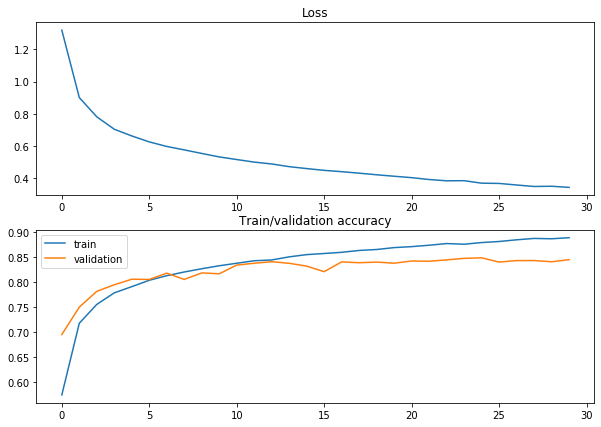

In [38]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [39]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8219


11)

128 батч

In [42]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-8)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.310854, Train accuracy: 0.579395, Val accuracy: 0.703228
Average loss: 0.882654, Train accuracy: 0.723015, Val accuracy: 0.756058
Average loss: 0.751384, Train accuracy: 0.765229, Val accuracy: 0.778172
Average loss: 0.683441, Train accuracy: 0.785824, Val accuracy: 0.799331
Average loss: 0.625629, Train accuracy: 0.803553, Val accuracy: 0.811480
Average loss: 0.590255, Train accuracy: 0.815446, Val accuracy: 0.814825
Average loss: 0.559308, Train accuracy: 0.823755, Val accuracy: 0.804587
Average loss: 0.533149, Train accuracy: 0.833294, Val accuracy: 0.813255
Average loss: 0.513421, Train accuracy: 0.838822, Val accuracy: 0.819057
Average loss: 0.496452, Train accuracy: 0.844094, Val accuracy: 0.824927
Average loss: 0.478325, Train accuracy: 0.849435, Val accuracy: 0.829704
Average loss: 0.469206, Train accuracy: 0.853752, Val accuracy: 0.831957
Average loss: 0.451028, Train accuracy: 0.856994, Val accuracy: 0.841854
Average loss: 0.435032, Train accuracy: 0.863052, V

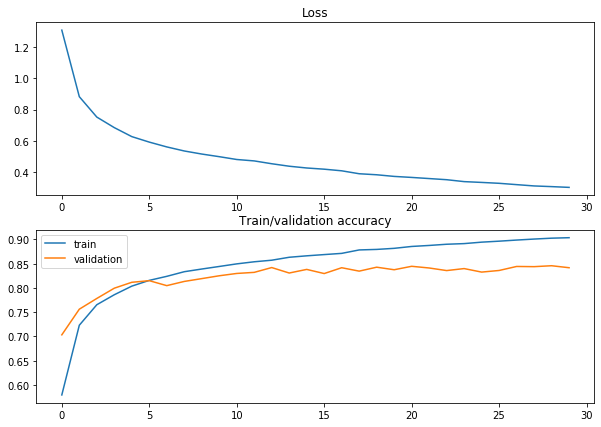

In [43]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [44]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8178


In [46]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=0.0008, weight_decay=1e-7)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.338283, Train accuracy: 0.575607, Val accuracy: 0.676063
Average loss: 0.892621, Train accuracy: 0.722093, Val accuracy: 0.745888
Average loss: 0.767630, Train accuracy: 0.759240, Val accuracy: 0.771347
Average loss: 0.678807, Train accuracy: 0.788042, Val accuracy: 0.791209
Average loss: 0.638926, Train accuracy: 0.800293, Val accuracy: 0.783974
Average loss: 0.594940, Train accuracy: 0.813756, Val accuracy: 0.805269
Average loss: 0.569292, Train accuracy: 0.821332, Val accuracy: 0.815712
Average loss: 0.541908, Train accuracy: 0.831468, Val accuracy: 0.805952
Average loss: 0.518974, Train accuracy: 0.837082, Val accuracy: 0.798103
Average loss: 0.502769, Train accuracy: 0.842951, Val accuracy: 0.827316
Average loss: 0.477530, Train accuracy: 0.851124, Val accuracy: 0.831138
Average loss: 0.470482, Train accuracy: 0.852609, Val accuracy: 0.831001
Average loss: 0.450985, Train accuracy: 0.859434, Val accuracy: 0.832571
Average loss: 0.438143, Train accuracy: 0.862250, V

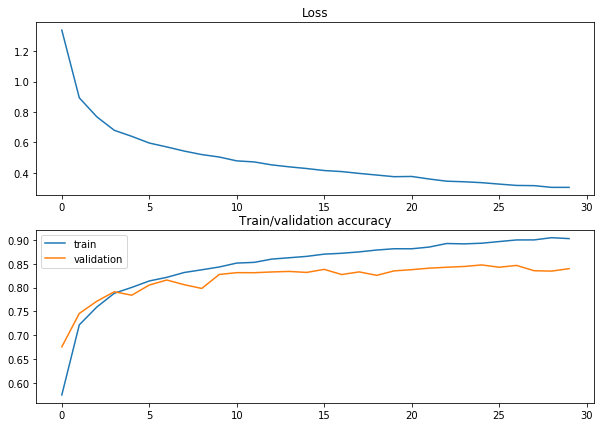

In [47]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [48]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8151


In [54]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=0.0008, weight_decay=1e-5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.343854, Train accuracy: 0.572723, Val accuracy: 0.684049
Average loss: 0.888650, Train accuracy: 0.724124, Val accuracy: 0.736673
Average loss: 0.753901, Train accuracy: 0.765775, Val accuracy: 0.776329
Average loss: 0.678770, Train accuracy: 0.788230, Val accuracy: 0.791823
Average loss: 0.628038, Train accuracy: 0.805822, Val accuracy: 0.777353
Average loss: 0.586828, Train accuracy: 0.818005, Val accuracy: 0.806020
Average loss: 0.559892, Train accuracy: 0.824950, Val accuracy: 0.811276
Average loss: 0.533537, Train accuracy: 0.833481, Val accuracy: 0.815985
Average loss: 0.516660, Train accuracy: 0.838737, Val accuracy: 0.798785
Average loss: 0.491156, Train accuracy: 0.847575, Val accuracy: 0.820490
Average loss: 0.482070, Train accuracy: 0.848667, Val accuracy: 0.824176
Average loss: 0.464282, Train accuracy: 0.853599, Val accuracy: 0.821787
Average loss: 0.450298, Train accuracy: 0.859246, Val accuracy: 0.824858
Average loss: 0.435546, Train accuracy: 0.863410, V

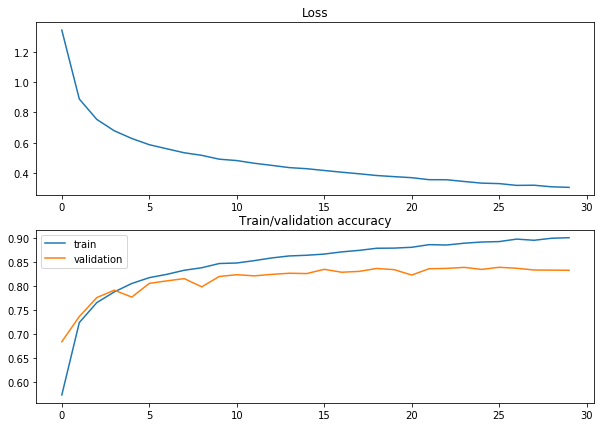

In [55]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [56]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8107


12)

In [14]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.671951, Train accuracy: 0.506296, Val accuracy: 0.667804
Average loss: 1.176618, Train accuracy: 0.685237, Val accuracy: 0.716333
Average loss: 0.987990, Train accuracy: 0.723578, Val accuracy: 0.748959
Average loss: 0.880263, Train accuracy: 0.748285, Val accuracy: 0.761723
Average loss: 0.810371, Train accuracy: 0.767618, Val accuracy: 0.780015
Average loss: 0.754224, Train accuracy: 0.783708, Val accuracy: 0.799126
Average loss: 0.720658, Train accuracy: 0.792905, Val accuracy: 0.789093
Average loss: 0.688166, Train accuracy: 0.803672, Val accuracy: 0.799126
Average loss: 0.669154, Train accuracy: 0.808091, Val accuracy: 0.799672
Average loss: 0.650149, Train accuracy: 0.815428, Val accuracy: 0.819125
Average loss: 0.633970, Train accuracy: 0.819558, Val accuracy: 0.816873
Average loss: 0.624301, Train accuracy: 0.822987, Val accuracy: 0.822674
Average loss: 0.608994, Train accuracy: 0.828533, Val accuracy: 0.826087
Average loss: 0.606713, Train accuracy: 0.828516, V

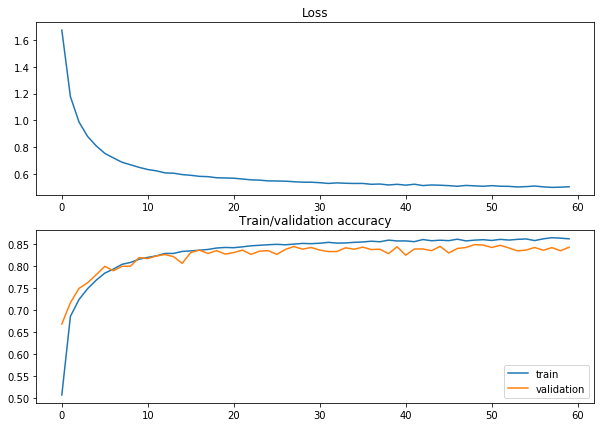

In [15]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [16]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8205


In [23]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.602322, Train accuracy: 0.531362, Val accuracy: 0.669852
Average loss: 1.109753, Train accuracy: 0.698836, Val accuracy: 0.708006
Average loss: 0.925946, Train accuracy: 0.739873, Val accuracy: 0.748823
Average loss: 0.817412, Train accuracy: 0.768778, Val accuracy: 0.768343
Average loss: 0.748973, Train accuracy: 0.786336, Val accuracy: 0.795099
Average loss: 0.699828, Train accuracy: 0.802273, Val accuracy: 0.809706
Average loss: 0.666871, Train accuracy: 0.810907, Val accuracy: 0.808614
Average loss: 0.640733, Train accuracy: 0.818824, Val accuracy: 0.819603
Average loss: 0.630391, Train accuracy: 0.819865, Val accuracy: 0.822674
Average loss: 0.607303, Train accuracy: 0.827526, Val accuracy: 0.828817
Average loss: 0.597821, Train accuracy: 0.830495, Val accuracy: 0.825473
Average loss: 0.588562, Train accuracy: 0.835409, Val accuracy: 0.829977
Average loss: 0.575438, Train accuracy: 0.839419, Val accuracy: 0.824176
Average loss: 0.571129, Train accuracy: 0.840818, V

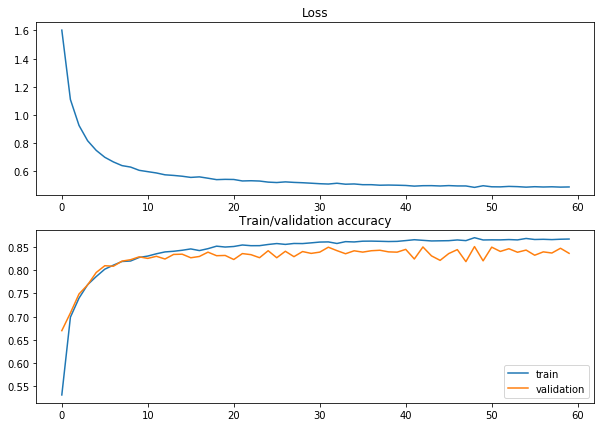

In [24]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [25]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8145


In [26]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.382712, Train accuracy: 0.552094, Val accuracy: 0.687052
Average loss: 0.928225, Train accuracy: 0.711685, Val accuracy: 0.738789
Average loss: 0.799149, Train accuracy: 0.751954, Val accuracy: 0.762337
Average loss: 0.725464, Train accuracy: 0.776217, Val accuracy: 0.773804
Average loss: 0.664277, Train accuracy: 0.793980, Val accuracy: 0.792301
Average loss: 0.625036, Train accuracy: 0.807375, Val accuracy: 0.795850
Average loss: 0.605010, Train accuracy: 0.813227, Val accuracy: 0.802130
Average loss: 0.577562, Train accuracy: 0.820462, Val accuracy: 0.811276
Average loss: 0.557372, Train accuracy: 0.826554, Val accuracy: 0.818306
Average loss: 0.532380, Train accuracy: 0.835119, Val accuracy: 0.808409
Average loss: 0.514881, Train accuracy: 0.839163, Val accuracy: 0.825541
Average loss: 0.503559, Train accuracy: 0.842815, Val accuracy: 0.823698
Average loss: 0.487265, Train accuracy: 0.847968, Val accuracy: 0.828203
Average loss: 0.476911, Train accuracy: 0.850169, V

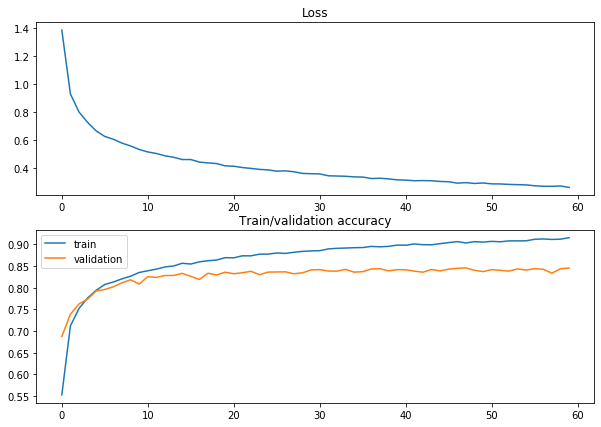

In [27]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [28]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8218


In [30]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True),
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.607039, Train accuracy: 0.522165, Val accuracy: 0.659409
Average loss: 1.070494, Train accuracy: 0.696686, Val accuracy: 0.723568
Average loss: 0.896043, Train accuracy: 0.739361, Val accuracy: 0.754897
Average loss: 0.796388, Train accuracy: 0.765690, Val accuracy: 0.771688
Average loss: 0.727136, Train accuracy: 0.785244, Val accuracy: 0.782745
Average loss: 0.683770, Train accuracy: 0.796505, Val accuracy: 0.793188
Average loss: 0.649578, Train accuracy: 0.807716, Val accuracy: 0.802130
Average loss: 0.614787, Train accuracy: 0.818500, Val accuracy: 0.817760
Average loss: 0.596157, Train accuracy: 0.826485, Val accuracy: 0.820831
Average loss: 0.580413, Train accuracy: 0.829830, Val accuracy: 0.825336
Average loss: 0.563525, Train accuracy: 0.834420, Val accuracy: 0.820558
Average loss: 0.550800, Train accuracy: 0.838941, Val accuracy: 0.823903
Average loss: 0.539075, Train accuracy: 0.841552, Val accuracy: 0.824449
Average loss: 0.529249, Train accuracy: 0.846466, V

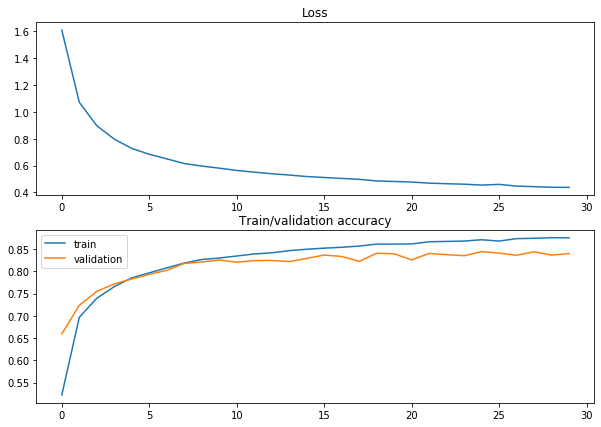

In [31]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [32]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8169


In [34]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True),
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 50), 
            nn.BatchNorm1d(50), 
            nn.ReLU(inplace=True), 
            nn.Linear(50, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.734134, Train accuracy: 0.499778, Val accuracy: 0.672104
Average loss: 1.215068, Train accuracy: 0.684452, Val accuracy: 0.710463
Average loss: 0.987324, Train accuracy: 0.731734, Val accuracy: 0.736195
Average loss: 0.855677, Train accuracy: 0.759308, Val accuracy: 0.773804
Average loss: 0.771625, Train accuracy: 0.778623, Val accuracy: 0.763634
Average loss: 0.717214, Train accuracy: 0.791557, Val accuracy: 0.783018
Average loss: 0.676513, Train accuracy: 0.803126, Val accuracy: 0.802539
Average loss: 0.648375, Train accuracy: 0.812067, Val accuracy: 0.814279
Average loss: 0.623931, Train accuracy: 0.817357, Val accuracy: 0.801720
Average loss: 0.602487, Train accuracy: 0.823192, Val accuracy: 0.810866
Average loss: 0.580630, Train accuracy: 0.830819, Val accuracy: 0.827179
Average loss: 0.569635, Train accuracy: 0.832594, Val accuracy: 0.829704
Average loss: 0.551752, Train accuracy: 0.838754, Val accuracy: 0.808614
Average loss: 0.542693, Train accuracy: 0.843395, V

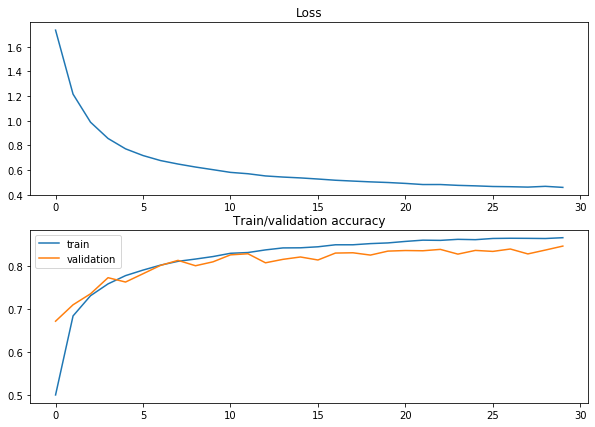

In [35]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [36]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8192


In [37]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True),
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 50), 
            nn.BatchNorm1d(50), 
            nn.ReLU(inplace=True), 
            nn.Linear(50, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.735437, Train accuracy: 0.472477, Val accuracy: 0.630742
Average loss: 1.244835, Train accuracy: 0.663277, Val accuracy: 0.693263
Average loss: 1.013256, Train accuracy: 0.723271, Val accuracy: 0.758242
Average loss: 0.867443, Train accuracy: 0.756612, Val accuracy: 0.755034
Average loss: 0.773405, Train accuracy: 0.781661, Val accuracy: 0.786226
Average loss: 0.710951, Train accuracy: 0.795209, Val accuracy: 0.796942
Average loss: 0.669493, Train accuracy: 0.806846, Val accuracy: 0.800560
Average loss: 0.640037, Train accuracy: 0.813449, Val accuracy: 0.812026
Average loss: 0.609829, Train accuracy: 0.822424, Val accuracy: 0.802403
Average loss: 0.595386, Train accuracy: 0.827100, Val accuracy: 0.800423
Average loss: 0.577613, Train accuracy: 0.831877, Val accuracy: 0.816122
Average loss: 0.565985, Train accuracy: 0.835938, Val accuracy: 0.820627
Average loss: 0.554006, Train accuracy: 0.839231, Val accuracy: 0.807044
Average loss: 0.540825, Train accuracy: 0.843190, V

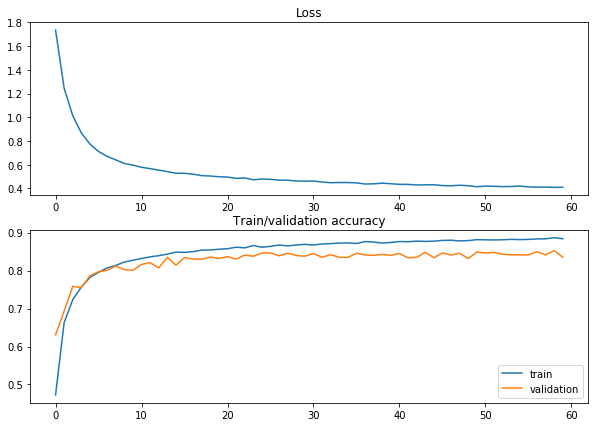

In [38]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [39]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8082


In [43]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 50), 
            nn.BatchNorm1d(50), 
            nn.ReLU(inplace=True), 
            nn.Linear(50, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.742255, Train accuracy: 0.466949, Val accuracy: 0.605556
Average loss: 1.245701, Train accuracy: 0.664164, Val accuracy: 0.689782
Average loss: 1.027150, Train accuracy: 0.713971, Val accuracy: 0.731008
Average loss: 0.897011, Train accuracy: 0.743439, Val accuracy: 0.750870
Average loss: 0.818097, Train accuracy: 0.762925, Val accuracy: 0.755170
Average loss: 0.763005, Train accuracy: 0.777821, Val accuracy: 0.785066
Average loss: 0.723146, Train accuracy: 0.790073, Val accuracy: 0.785202
Average loss: 0.693205, Train accuracy: 0.796676, Val accuracy: 0.776398
Average loss: 0.664949, Train accuracy: 0.804286, Val accuracy: 0.793393
Average loss: 0.639243, Train accuracy: 0.812630, Val accuracy: 0.807999
Average loss: 0.625704, Train accuracy: 0.816589, Val accuracy: 0.806634
Average loss: 0.608225, Train accuracy: 0.820087, Val accuracy: 0.818852
Average loss: 0.590609, Train accuracy: 0.827731, Val accuracy: 0.815576
Average loss: 0.583804, Train accuracy: 0.829471, V

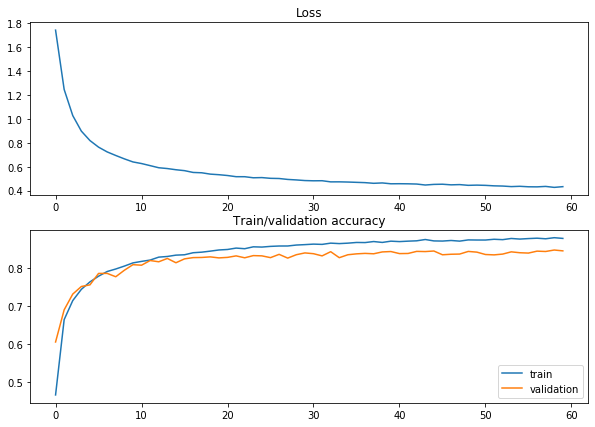

In [44]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [45]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8177


In [46]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 80), 
            nn.BatchNorm1d(80), 
            nn.ReLU(inplace=True),
            nn.Linear(80, 50), 
            nn.BatchNorm1d(50), 
            nn.ReLU(inplace=True), 
            nn.Linear(50, 10),
         )

num_epochs = 60  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs)

Average loss: 1.761709, Train accuracy: 0.465618, Val accuracy: 0.620162
Average loss: 1.261363, Train accuracy: 0.658892, Val accuracy: 0.694082
Average loss: 1.044710, Train accuracy: 0.710132, Val accuracy: 0.724183
Average loss: 0.914651, Train accuracy: 0.739429, Val accuracy: 0.748413
Average loss: 0.828011, Train accuracy: 0.760468, Val accuracy: 0.760835
Average loss: 0.764520, Train accuracy: 0.778538, Val accuracy: 0.783086
Average loss: 0.724050, Train accuracy: 0.788332, Val accuracy: 0.794417
Average loss: 0.694225, Train accuracy: 0.797393, Val accuracy: 0.794758
Average loss: 0.662562, Train accuracy: 0.807085, Val accuracy: 0.804860
Average loss: 0.642825, Train accuracy: 0.812067, Val accuracy: 0.802812
Average loss: 0.625570, Train accuracy: 0.817459, Val accuracy: 0.806430
Average loss: 0.615693, Train accuracy: 0.819558, Val accuracy: 0.809160
Average loss: 0.600489, Train accuracy: 0.825189, Val accuracy: 0.823562
Average loss: 0.583091, Train accuracy: 0.829864, V

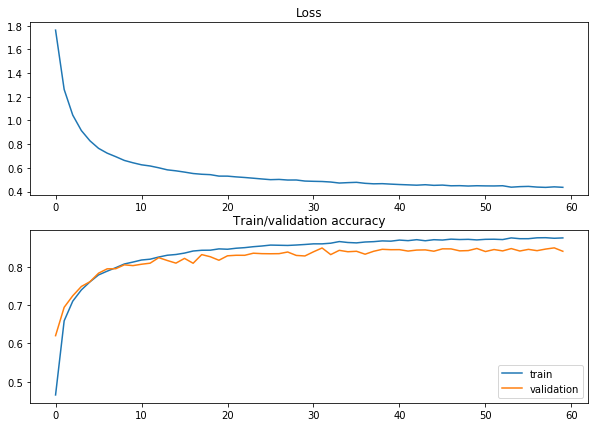

In [47]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [48]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8182
